In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [98]:
df = pd.read_csv('CMS_60_50_Ni_Column.csv')
df

,Days,50,60
0,9,0.000000,0.000000
1,10,0.016022,0.011274
2,11,0.033375,0.029461
3,12,0.053447,0.057171
4,13,0.068962,0.079701
...,...,...,...
61,70,0.374950,0.479551
62,71,0.377158,0.481204
63,72,0.379258,0.482578
64,73,0.380902,0.483954


In [99]:
temps = [temp for temp in df.columns][1:]
temps
for i,temp in enumerate(temps):
    print(df[df.columns[i]])

0      9
1     10
2     11
3     12
4     13
      ..
61    70
62    71
63    72
64    73
65    74
Name: Days, Length: 66, dtype: int64
0     0.000000
1     0.016022
2     0.033375
3     0.053447
4     0.068962
        ...   
61    0.374950
62    0.377158
63    0.379258
64    0.380902
65    0.382442
Name: 50, Length: 66, dtype: float64


In [100]:
def plot_recoveries (df):
    t = np.array(df[df.columns[0]])
    temps = [temp for temp in df.columns][1:]
    plt.figure(figsize = (10,8))
    #plt.plot(t,[df[df.columns[i+1]] for i in range(len(temps))])
    for i,temp in enumerate(temps):
        plt.plot(t,df[df.columns[i+1]] , label = str(temp))
    plt.xlabel(df.columns[0])
    plt.ylabel('Extraction')
    plt.legend()
    plt.show()

def surface_chem(df):
    arrs = [np.array(df[col]) for col in df.columns[1:]]
    LH = [(1 - (1-arrs[i])**(1/3)) for i in range(len(arrs))]
    model_linear = "1 - (1-X)**(1/3)"
    return(LH,model_linear)

def diffusion(df):
    arrs = [np.array(df[col]) for col in df.columns[1:]]
    LH = [(1 - (2/3)*arrs[i]-(1-arrs[i])**(2/3)) for i in range(len(arrs))]
    model_linear = "1 - (2/3)*X - (1-X)**(2/3)"
    model_name = 'Diffusion'
    return(LH, model_linear)

def plot_linear_model(df,LH,linear_model,model_name):
    t = np.array(df[df.columns[0]])
    temps = [temp for temp in df.columns][1:]
    plt.figure(figsize = (10,8))
    for i,entry in enumerate(LH):
        res = stats.linregress(t,entry)
        plt.plot(t,res.intercept + res.slope*t)
        plt.scatter(t,entry)
        plt.ylabel(linear_model)
        plt.xlabel('t')
        plt.title(model_name)
        print(temps[i],res.slope*1000,res.rvalue)
        #plt.legend(temps) still need to fix this
        

def plot_linear_kinetic_selected_models (selected_models):
    for model in selected_models:
        LH = model(df)[0]
        model_linear = model(df)[1]
        model_name = model.__name__
        plot_linear_model(df,LH,model_linear,model_name)
        
def evaluate(df,LH):
    t = np.array(df[df.columns[0]])
    temps = [temp for temp in df.columns][1:]
    res_temps = []
    res_slopes = []
    res_rvalues= []
    for i,entry in enumerate(LH):
        res = stats.linregress(t,entry)
        res_temps.append(temps[i])
        res_slopes.append(res.slope*1000)
        res_rvalues.append(res.rvalue)
        res_df = pd.DataFrame({'Temperature': res_temps, 
                          'k_value': res_slopes,
                          'r_value': res_rvalues})
    return(res_df)

def evaluate_selected_models (selected_models):
    res_collection = []
    for model in selected_models:
        LH = model(df)[0]
        TC_kvalue_rvalue_df = evaluate(df,LH)
        res_tuple = (np.average(TC_kvalue_rvalue_df['r_value']),model)
        res_collection.append(res_tuple)
    res_collection_sorted = sorted(res_collection, reverse = True)
    best_model = res_collection_sorted[0][1]
    rvalues = [entry[0] for entry in res_collection_sorted]
    models_ = [entry[1].__name__ for entry in res_collection_sorted]        
    model_matrix = pd.DataFrame({'Rvalue':rvalues,
                                 'Model':models_})
    model_matrix.index += 1
    print(model_matrix)
    return(best_model)

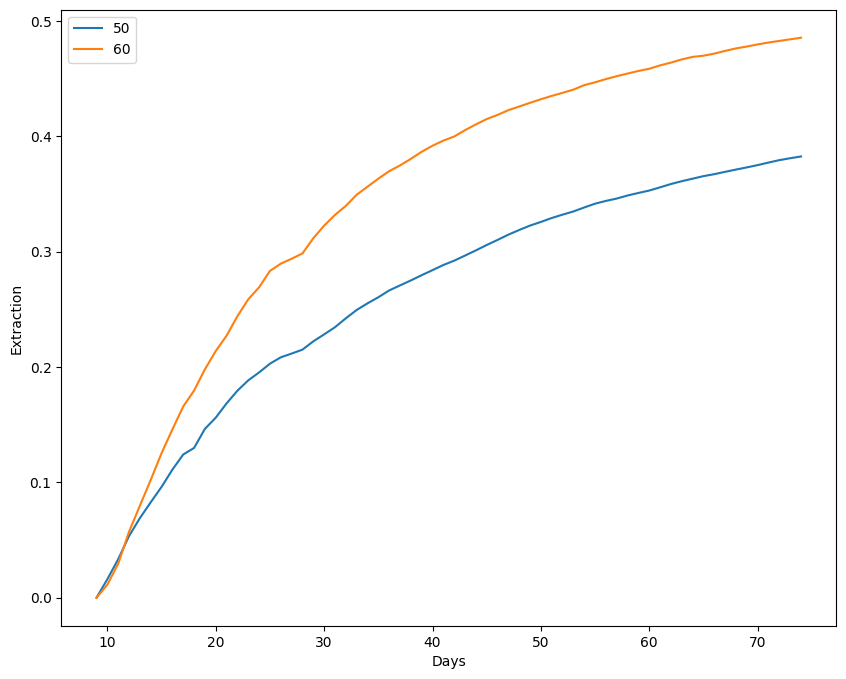

In [101]:
selected_models = [surface_chem,diffusion]
plot_recoveries(df)

50 2.0635374124130195 0.9657115151808283
60 2.7798983394956984 0.944474173061011
50 0.32879035721365274 0.9968959167531365
60 0.5732593693490582 0.9866196968818857


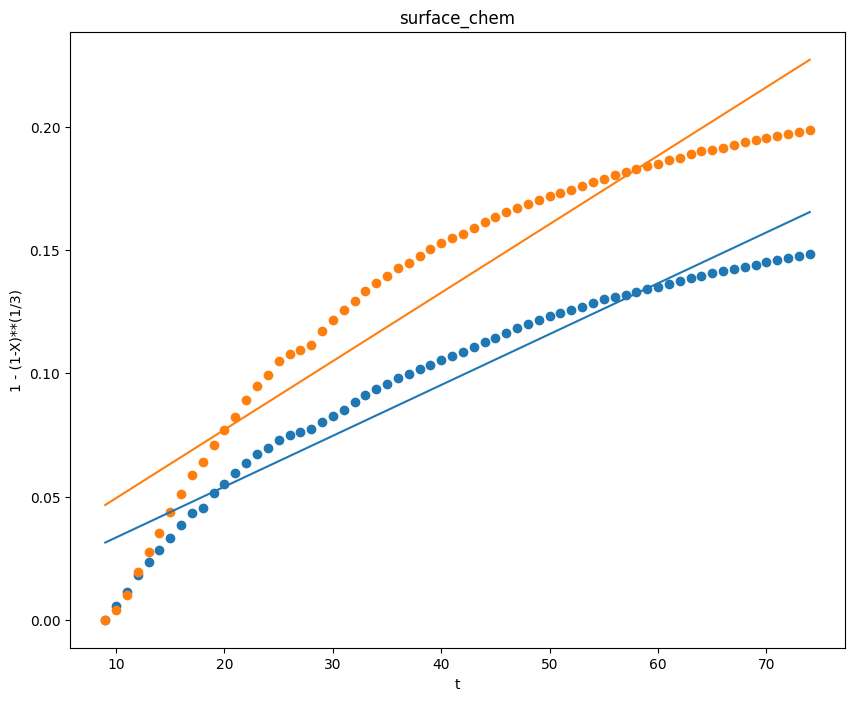

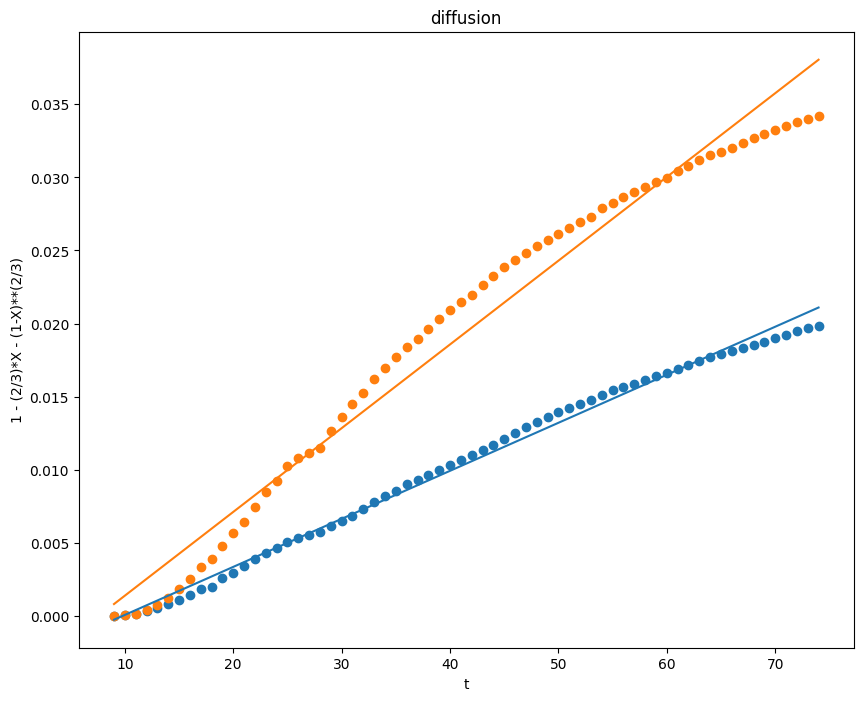

In [102]:
plot_linear_kinetic_selected_models(selected_models)

     Rvalue         Model
1  0.991758     diffusion
2  0.955093  surface_chem

Best Model Name: diffusion
Model RValue: 1.0
Model Slope: -5.985 

Collision Frequency (A): 36326967.0 
Activation Energy: 49.76 Kj/mol


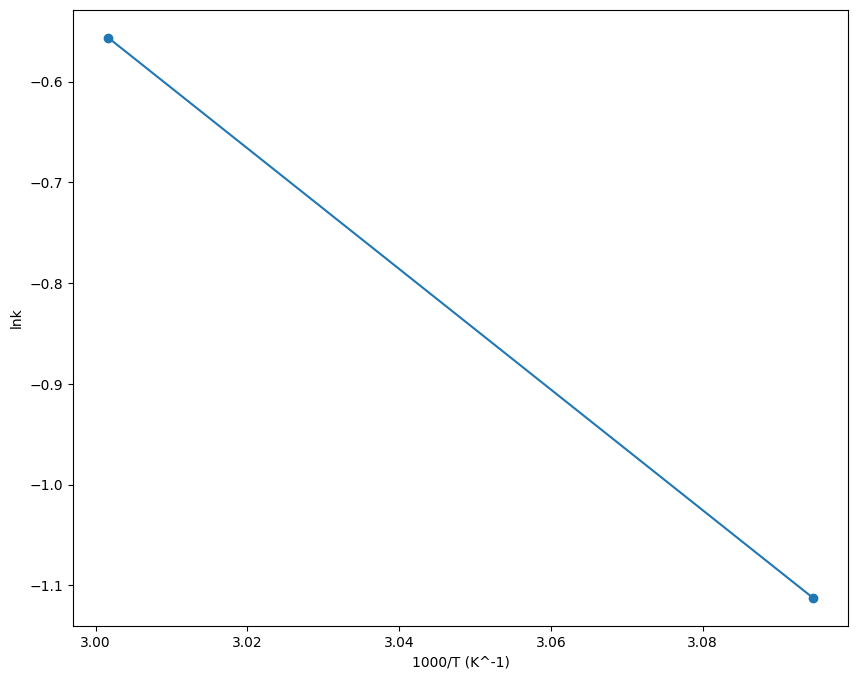

In [103]:
best_model = evaluate_selected_models(selected_models)
TC_kvalue_rvalue_df = evaluate(df,best_model(df)[0])
TC_kvalue_rvalue_df['lnk'] = np.log(TC_kvalue_rvalue_df['k_value'])
TC_kvalue_rvalue_df['1000/T'] = 1000/(TC_kvalue_rvalue_df['Temperature'].astype(int)+273.15)
plt.figure(figsize = (10,8))
plt.scatter(TC_kvalue_rvalue_df['1000/T'],TC_kvalue_rvalue_df['lnk'])
EA_regress = stats.linregress(TC_kvalue_rvalue_df['1000/T'], TC_kvalue_rvalue_df['lnk'])
plt.plot(TC_kvalue_rvalue_df['1000/T'] , (EA_regress.intercept + (EA_regress.slope * TC_kvalue_rvalue_df['1000/T'])))
plt.xlabel('1000/T (K^-1)')
plt.ylabel('lnk')
best_model_rvalue = abs(EA_regress.rvalue)
print()
print("Best Model Name: {}".format(best_model.__name__))
print("Model RValue: {}".format(np.round(best_model_rvalue,3)))
print("Model Slope: {} ".format(np.round(EA_regress.slope,3)))
print()
A = np.exp(EA_regress.intercept)
Ea = -1 * EA_regress.slope * 8.314
print("Collision Frequency (A): {} ".format(np.round(A,0)))
print("Activation Energy: {} Kj/mol".format(np.round(Ea,2))) #KJ/mol because we multplied temperature by 1000

ValueError: x and y must have same first dimension, but have shapes (3,) and (1,)

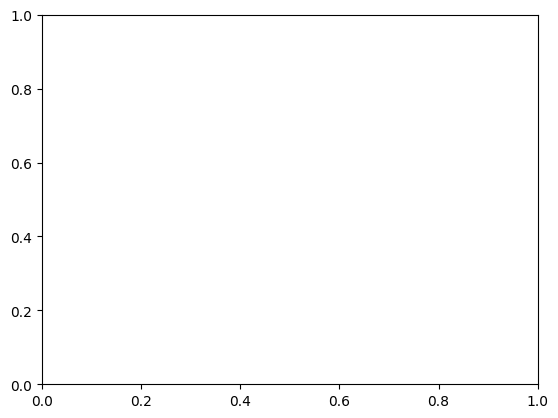

In [104]:
a = [1,2,3]
b = [10,20,30]
for i,entry in enumerate(b):
    plt.plot(a,b[i])